In [2]:
#Importing all packages 

import pandas as pd
import numpy as np


import math

import operator
import statsmodels
from statsmodels import api as sm 

from statsmodels.tsa.stattools import adfuller 

from datetime import datetime



from numpy import log,polyfit,sqrt,std,subtract
import statsmodels.tsa.stattools as ts

from statsmodels.tsa.stattools import coint

import nsepy 

import seaborn as sns

import math

!pip install ffn
import ffn

!pip install pykalman 
from pykalman import KalmanFilter


from datetime import date
from nsepy import get_history
from nsepy.derivatives import get_expiry_date



In [3]:
#Reading in list of companies that have futures on NSE 
underlying=pd.read_csv('Underlying.csv').iloc[:,[0,1]]

underlying.head()

,Company,Symbol
0,ACC LIMITED,ACC
1,ADANI ENTERPRISES LIMITED,ADANIENT
2,ADANI PORT & SEZ LTD,ADANIPORTS
3,ADANI POWER LTD,ADANIPOWER
4,AJANTA PHARMA LIMITED,AJANTPHARM


In [ ]:
#Scrapping futures data from NSE using nsepy

"""n_days=[31,28,31,30,31,30,31,31,30,31,30,31]

data=pd.DataFrame(columns=['Symbol','Close'])

for year in range(2014,2019):
    for month in range(1,13):
        for ticker in underlying.Symbol:
            stock_fut = get_history(symbol=ticker,start=date(year,month,1),end=date(year,month,n_days[month-1]),futures=True,expiry_date=get_expiry_date(year,month)).iloc[:,[0,5]]
            data=data.append(stock_fut)
data.to_csv("data.csv") """      

In [4]:

#Removing missing values ( taking only those futures that traded for the entire duration and getting it in the right format)
data=pd.DataFrame(columns=['Symbol','Close'])

data=pd.read_csv('data.csv')

data.rename(columns={"Unnamed: 0": "Date"},inplace=True)

data

data=data.pivot(values="Close",columns="Symbol",index="Date")

data.reset_index(inplace=True)

data.dropna(axis='columns',how='any',inplace=True)

data.to_csv("data_needed.csv")
data.head()

Symbol,Date,ACC,ADANIENT,ADANIPORTS,ADANIPOWER,ALBK,AMBUJACEM,APOLLOHOSP,APOLLOTYRE,ARVIND,...,TECHM,TITAN,UBL,ULTRACEMCO,UNIONBANK,UPL,VOLTAS,WIPRO,YESBANK,ZEEL
0,2014-01-01,1119.20,271.55,158.05,39.85,97.60,185.10,977.45,106.05,140.05,...,1846.75,233.10,774.65,1781.75,132.65,200.65,119.25,554.40,378.35,279.55
1,2014-01-02,1101.60,256.15,153.60,37.35,95.35,180.15,939.20,103.55,142.75,...,1830.80,228.10,746.10,1738.90,127.20,197.85,117.30,554.95,364.35,280.60
2,2014-01-03,1092.55,250.70,151.30,36.70,96.90,178.40,959.65,106.10,145.50,...,1851.85,229.40,760.70,1732.80,129.60,201.70,115.70,559.65,372.55,282.40
3,2014-01-06,1089.90,254.15,152.05,37.25,94.45,177.30,951.90,106.70,153.65,...,1831.75,229.55,778.75,1731.85,126.65,203.20,122.10,560.60,368.40,289.40
4,2014-01-07,1089.00,243.90,147.15,36.20,93.45,176.25,937.90,106.95,154.60,...,1814.10,227.50,759.25,1700.00,124.80,203.00,121.70,550.30,367.20,286.80


In [5]:
def load_data():
    all_contracts=pd.read_csv("data_needed.csv",index_col='Date',parse_dates=True)
    used_stocks=list(all_contracts.columns.values)
    
    return all_contracts[1220-252-252:1220-252],used_stocks

In [6]:
def regress(x,y):
    x=sm.add_constant(x)
    model=sm.OLS(endog=y,exog=x)
    result=model.fit()
    return result

In [7]:
#Modelling OU process
def OU(result):
    
    residuals=pd.DataFrame()
    residuals["Residual"]=result.resid
    residuals.reset_index(inplace=True)
  
   
   
    x=[residuals.Residual.loc[0]]
    y=[]
    for i in range(1,len(residuals)):
         x.append(x[-1]+residuals.Residual.loc[i])
            
    for i in range(1,len(x)):
         y.append(x[i-1])
    
    x=x[1:]
    x=pd.DataFrame(x,columns=["X"])

    y=pd.DataFrame(y,columns=["Y"])

   
   
    new_result=regress(x["X"],y["Y"])

    
    a=new_result.params[0]
    b=new_result.params[1]

    var=new_result.mse_resid
    mu=a/(1-b)
    theta=-math.log(b)*252
    
    sigma=(var/(1-(b*b)))**0.5
    
    return (mu,sigma,-b,x.X.loc[len(x.X)-1])

In [8]:
def backtest(s1,s2,x,y):
    window=60
    df3=pd.DataFrame({'y':y,'x':x})   #df3 has prices 
    df2=(df3-df3.shift(1))/df3    # calculating and storing returns 
    df2.iloc[0]=1               
    df1=df2.iloc[window:]
    df1['x_price']=df3.x.iloc[window:]
    df1['y_price']=df3.y.iloc[window:]
    
    hr=[]
    spread=[]
    meanSpread=[]
    stdSpread=[]
    zScore=[]
    for i in range(len(df1)):
        result=regress(df2.x.iloc[i:i+window],df2.y.iloc[i:i+window])
        h=result.params[1]
        hr.append(h)
        mu,sigma,h1,xt=OU(result)
        z=(xt-mu)/sigma
        zScore.append(z)
        
    df1['zScore']=zScore
    df1['hr']=hr
   
    df1['spread']=df1.y_price+(df1.x_price*df1.hr)
    
 
    
    entryZscore=2
    exitZscore=0
    stoploss=3
    
    df1['long entry']=((df1.zScore< - entryZscore) & (df1.zScore.shift(1) > - entryZscore))
    df1['long exit']=(((df1.zScore>- exitZscore) & (df1.zScore.shift(1) < - exitZscore))|((df1.zScore<- stoploss) & (df1.zScore.shift(1) > - stoploss))) 
    df1['num units long']=np.nan
    df1.loc[df1['long entry'],'num units long']=1
    df1.loc[df1['long exit'],'num units long']=0
    df1['num units long'][0]=0
    df1['num units long']=df1['num units long'].fillna(method='pad')
    if df1['num units long'].sum()==0:
        entryZscore=1
        df1['long entry']=((df1.zScore< - entryZscore) & (df1.zScore.shift(1) > - entryZscore))
        df1['long exit']=(((df1.zScore>- exitZscore) & (df1.zScore.shift(1) < - exitZscore)) |((df1.zScore<- stoploss) & (df1.zScore.shift(1) > - stoploss)))
        df1.loc[df1['long entry'],'num units long']=1
        df1.loc[df1['long exit'],'num units long']=0
        df1['num units long'][0]=0
        df1['num units long']=df1['num units long'].fillna(method='pad')
    else:
        entryZscore=2
        
    df1['short entry']=((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit']=(((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))|((df1.zScore > stoploss) & (df1.zScore.shift(1) < stoploss)))
    df1.loc[df1['short entry'],'num units short']=-1
    df1.loc[df1['short exit'],'num units short']=0
    df1['num units short'][0]=0
    df1['num units short']=df1['num units short'].fillna(method='pad')
        
        
    df1['numUnits']=df1['num units long']+df1['num units short']
    df1['spread pct ch']=(df1['spread']-df1['spread'].shift(1))/((df1['x_price']*abs(df1['hr']))+df1['y_price'])
    df1['port rets']=df1['spread pct ch']*df1['numUnits'].shift(1)
    df1['cum rets']=df1['port rets'].cumsum()
    df1['cum rets']=df1['cum rets']+1
        
    try:
        sharpe=((df1['port rets'].mean()/df1['port rets'].std()))*sqrt(252)
    except ZeroDivisionError:
        sharpe=0.0
   
    print(df1)
    return df1['cum rets'],sharpe
    
        
    
    
    
    
    

In [75]:
def find_cointegrated_pairs(data, significance=0.10):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j],pvalue))
    return  pvalue_matrix, pairs

In [76]:
#loading data and finding cointegrated pairs 

all_contracts,used_stock=load_data()
all_contracts=all_contracts.dropna()
pvalue_matrix,pairs=find_cointegrated_pairs(all_contracts)


In [45]:
pairs

[('Unnamed: 0', 'INDIACEM', 0.023649696806916486),
 ('Unnamed: 0', 'JSWSTEEL', 0.04194829400769441),
 ('Unnamed: 0', 'JUBLFOOD', 0.021353292075305032),
 ('Unnamed: 0', 'LICHSGFIN', 0.02609968709650675),
 ('Unnamed: 0', 'RECLTD', 0.014545360456687072),
 ('ACC', 'EXIDEIND', 0.029762194634791548),
 ('ADANIENT', 'JISLJALEQS', 0.0243133091042596),
 ('ADANIPORTS', 'BHARTIARTL', 0.04370603996159721),
 ('ADANIPORTS', 'BPCL', 0.04944838285078904),
 ('ADANIPORTS', 'DISHTV', 0.03786846370331116),
 ('ADANIPORTS', 'HINDALCO', 0.002726295456223535),
 ('ADANIPORTS', 'HINDZINC', 0.018259634144262172),
 ('ADANIPORTS', 'LT', 0.016853451613302206),
 ('ADANIPORTS', 'NTPC', 0.046151270383861596),
 ('ADANIPORTS', 'PETRONET', 0.03689869506125083),
 ('ADANIPORTS', 'TATASTEEL', 0.001947561541431751),
 ('ADANIPOWER', 'CENTURYTEX', 0.0367727043441994),
 ('ADANIPOWER', 'GAIL', 0.0004929069598147934),
 ('ADANIPOWER', 'IDEA', 0.033470345397484606),
 ('ADANIPOWER', 'PNB', 0.00294303683821913),
 ('ADANIPOWER', 'ULTRA

In [77]:
pairs_df=pd.DataFrame(pairs)
pairs_df.columns=['S1','S2','Pvalue']
pairs_df.index.name='id'
pairs_df=pairs_df.sort_values(by=['Pvalue'],ascending=True) 
number_pairs=len(pairs_df)
p_sorted_all=pairs_df[0:number_pairs]

In [78]:
pairs_df=pairs_df[pairs_df.S1!="Unnamed: 0"]
pairs_df=pairs_df[pairs_df.S2!="Unnamed: 0"]

In [79]:
len(pairs_df)

912

In [80]:
print("No of pairs satisfying the p-value criteria= "+str(len(pairs_df)))

No of pairs satisfying the p-value criteria= 912


In [81]:
industry=pd.read_csv("Underlying_Industry.csv")

industry.set_index("Symbol",inplace=True)

industry=industry["Industry Name "]

industry.loc["TATAMTRDVR"]="Diversified automobile"

sect_list=[]
for i,pair in pairs_df.iterrows():
    if industry[pair["S1"]]==industry[pair["S2"]]:
        sect_list.append(pair)

len(sect_list)
sect_list=pd.DataFrame(sect_list)

In [82]:
sect_list

,S1,S2,Pvalue
768,INDUSINDBK,ORIENTBANK,0.000767
611,HDFC,ORIENTBANK,0.003602
816,KTKBANK,UNIONBANK,0.005722
765,INDUSINDBK,KTKBANK,0.007272
228,CANBK,PNB,0.013887
227,CANBK,KTKBANK,0.015852
654,HEXAWARE,TECHM,0.017350
232,CANBK,UNIONBANK,0.018374
189,BANKBARODA,INDUSINDBK,0.021240
605,HDFC,KTKBANK,0.022549


In [51]:
p_sorted=p_sorted_all[0:20]

In [54]:
p_sorted

,S1,S2,Pvalue
id,,,
81,AXISBANK,SAIL,0.000006
82,AXISBANK,SUNTV,0.000012
79,AXISBANK,JISLJALEQS,0.000041
75,AXISBANK,DLF,0.000077
352,INDUSINDBK,RECLTD,0.000112
174,DRREDDY,INDUSINDBK,0.000117
84,AXISBANK,ZEEL,0.000250
17,ADANIPOWER,GAIL,0.000493
83,AXISBANK,UBL,0.000645


In [83]:

#Doing in sample backtesting and selecting only those pairs that have positive sharpe ratio 
list_sect=[]
ret=pd.DataFrame()
#for i in np.arange(p_sorted.shape[0]):
for i in np.arange(len(sect_list)):
    
    s1=pd.DataFrame(sect_list).iloc[i][1]
    s2=pd.DataFrame(sect_list).iloc[i][0]
    name=s1+"-"+s2
    x=all_contracts[s1]
    y=all_contracts[s2]
    tmp,sharpe=backtest(s1,s2,x,y)
    print('{} and {} has a sharpe ratio of:{}'.format(s1,s2,sharpe))
    if sharpe>0 :
        ret[name]=tmp.values
        list_sect.append((s1,s2))

/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.000758  0.022153   144.45  1516.40  0.663770  0.955224   
2017-07-07  0.004268 -0.020848   141.50  1522.90  0.207935  0.098569   
2017-07-10  0.021115  0.063224   151.05  1555.75  0.739051  0.090779   
2017-07-11 -0.000482 -0.028951   146.80  1555.00  0.899448  0.105873   
2017-07-12  0.010468  0.023612   150.35  1571.45  0.597148  0.107383   
2017-07-13  0.002729 -0.003002   149.90  1575.75  1.199062  0.109293   
2017-07-14 -0.000667 -0.002340   149.55  1574.70  0.986023  0.105708   
2017-07-17  0.004551  0.004659   150.25  1581.90  1.010395  0.104132   
2017-07-18 -0.003871 -0.001667   150.00  1575.80  0.911301  0.105194   
2017-07-19  0.002848  0.002991   150.45  1580.30  1.034831  0.107217   
2017-07-20 -0.009615 -0.002332   150.10  1565.25  0.985417  0.107463   
2017-07-21  0.002803  0.003320   150.60  1569.65  0.744243  0.10

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.009323  0.022153   144.45  1635.70  0.704686  0.950944   
2017-07-07 -0.009131 -0.020848   141.50  1620.90  0.274532  0.008713   
2017-07-10  0.004055  0.063224   151.05  1627.50 -0.073453  0.014406   
2017-07-11  0.001626 -0.028951   146.80  1630.15  0.433944  0.018860   
2017-07-12 -0.001351  0.023612   150.35  1627.95 -0.257757  0.028547   
2017-07-13  0.009009 -0.003002   149.90  1642.75 -0.610566  0.027743   
2017-07-14  0.003337 -0.002340   149.55  1648.25 -0.349664  0.027213   
2017-07-17  0.004920  0.004659   150.25  1656.40 -0.773295  0.044405   
2017-07-18  0.001206 -0.001667   150.00  1658.40 -0.507450  0.042991   
2017-07-19  0.000813  0.002991   150.45  1659.75 -0.857880  0.040058   
2017-07-20 -0.002264 -0.002332   150.10  1656.00 -0.753008  0.039645   
2017-07-21 -0.007974  0.003320   150.60  1642.90 -0.852935  0.03

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.006999  0.024183   153.00   164.30 -0.849633  0.976064   
2017-07-07  0.010837 -0.013245   151.00   166.10 -1.642870  0.380250   
2017-07-10  0.010721  0.041574   157.55   167.90 -1.536348  0.374699   
2017-07-11 -0.023157 -0.031086   152.80   164.10 -1.574966  0.365623   
2017-07-12  0.013822  0.013239   154.85   166.40 -1.341471  0.366236   
2017-07-13 -0.005438  0.003539   155.40   165.50 -1.121525  0.371396   
2017-07-14  0.005409  0.002567   155.80   166.40 -1.385225  0.365301   
2017-07-17 -0.046870  0.002880   156.25   158.95 -1.459655  0.363486   
2017-07-18 -0.002839  0.000320   156.30   158.50 -0.610523  0.307461   
2017-07-19 -0.004436  0.003189   156.80   157.80 -1.078031  0.294882   
2017-07-20  0.007235 -0.017191   154.15   158.95 -1.171778  0.293557   
2017-07-21 -0.008566  0.004842   154.90   157.60 -1.220894  0.28

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.000758  0.006999   164.30  1516.40  0.926539  0.962643   
2017-07-07  0.004268  0.010837   166.10  1522.90  0.073267  0.056886   
2017-07-10  0.021115  0.010721   167.90  1555.75  0.691772  0.059590   
2017-07-11 -0.000482 -0.023157   164.10  1555.00  0.911437  0.065459   
2017-07-12  0.010468  0.013822   166.40  1571.45  0.599821  0.069573   
2017-07-13  0.002729 -0.005438   165.50  1575.75  1.289520  0.072019   
2017-07-14 -0.000667  0.005409   166.40  1574.70  0.883600  0.068364   
2017-07-17  0.004551 -0.046870   158.95  1581.90  1.178541  0.065983   
2017-07-18 -0.003871 -0.002839   158.50  1575.80  1.026444  0.069733   
2017-07-19  0.002848 -0.004436   157.80  1580.30  1.209199  0.075931   
2017-07-20 -0.009615  0.007235   158.95  1565.25  1.187309  0.075431   
2017-07-21  0.002803 -0.008566   157.60  1569.65  0.942217  0.07

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203  0.038856   141.55   338.80 -0.332926  0.985809   
2017-07-07  0.004408  0.008059   142.70   340.30 -0.884470  0.574470   
2017-07-10  0.056687  0.069449   153.35   360.75 -1.381527  0.588268   
2017-07-11 -0.019500 -0.024382   149.70   353.85 -0.921515  0.627378   
2017-07-12  0.012144  0.019325   152.65   358.20 -0.730629  0.630223   
2017-07-13  0.004724  0.000327   152.70   359.90 -0.795597  0.628628   
2017-07-14  0.020014  0.009728   154.20   367.25 -0.945736  0.623745   
2017-07-17 -0.000136 -0.005215   153.40   367.20 -0.667886  0.625640   
2017-07-18  0.005148  0.012234   155.30   369.10 -0.788155  0.636306   
2017-07-19  0.007262  0.023577   159.05   371.80 -1.029403  0.633149   
2017-07-20 -0.052661 -0.011125   157.30   353.20 -1.032512  0.625450   
2017-07-21 -0.004265  0.009134   158.75   351.70 -2.466099  0.64

/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203  0.006999   164.30   338.80 -0.535718  0.974607   
2017-07-07  0.004408  0.010837   166.10   340.30 -0.823631  0.353929   
2017-07-10  0.056687  0.010721   167.90   360.75 -0.817532  0.353957   
2017-07-11 -0.019500 -0.023157   164.10   353.85 -0.286359  0.364389   
2017-07-12  0.012144  0.013822   166.40   358.20 -0.327050  0.368555   
2017-07-13  0.004724 -0.005438   165.50   359.90 -0.272228  0.370172   
2017-07-14  0.020014  0.005409   166.40   367.25 -0.451407  0.363302   
2017-07-17 -0.000136 -0.046870   158.95   367.20 -0.119335  0.362222   
2017-07-18  0.005148 -0.002839   158.50   369.10 -0.169276  0.377883   
2017-07-19  0.007262 -0.004436   157.80   371.80 -0.150672  0.378718   
2017-07-20 -0.052661  0.007235   158.95   353.20  0.028972  0.379009   
2017-07-21 -0.004265 -0.008566   157.60   351.70 -0.703266  0.36

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.003335 -0.003657   369.20   239.90 -0.535095  0.989533   
2017-07-07 -0.008407  0.007927   372.15   237.90 -0.446716  0.628105   
2017-07-10  0.033712  0.012603   376.90   246.20 -0.737328  0.618529   
2017-07-11  0.027070  0.002118   377.70   253.05 -0.740970  0.637198   
2017-07-12  0.000592  0.004218   379.30   253.20 -0.398772  0.645781   
2017-07-13 -0.024272  0.003154   380.50   247.20 -0.740085  0.642815   
2017-07-14 -0.017284 -0.001052   380.10   243.00 -1.020017  0.631176   
2017-07-17  0.005118  0.010672   384.20   244.25 -1.458768  0.628929   
2017-07-18  0.002654 -0.001564   383.60   244.90 -1.562248  0.625321   
2017-07-19  0.012898  0.014515   389.25   248.10 -1.464129  0.625249   
2017-07-20 -0.008947 -0.017115   382.70   245.90 -1.757020  0.610099   
2017-07-21 -0.009442  0.009447   386.35   243.60 -1.371917  0.62

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203  0.024183   153.00   338.80 -1.598172  0.987633   
2017-07-07  0.004408 -0.013245   151.00   340.30 -1.719174  0.704680   
2017-07-10  0.056687  0.041574   157.55   360.75 -1.375585  0.701794   
2017-07-11 -0.019500 -0.031086   152.80   353.85 -0.869739  0.730288   
2017-07-12  0.012144  0.013239   154.85   358.20 -0.795601  0.728043   
2017-07-13  0.004724  0.003539   155.40   359.90 -0.617280  0.730971   
2017-07-14  0.020014  0.002567   155.80   367.25 -0.639257  0.729599   
2017-07-17 -0.000136  0.002880   156.25   367.20 -0.434443  0.734828   
2017-07-18  0.005148  0.000320   156.30   369.10 -0.590982  0.735388   
2017-07-19  0.007262  0.003189   156.80   371.80 -0.529420  0.736689   
2017-07-20 -0.052661 -0.017191   154.15   353.20 -0.255298  0.738210   
2017-07-21 -0.004265  0.004842   154.90   351.70 -1.521370  0.75

/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shr

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.007662  0.000758  1516.40   163.15 -0.863945  0.999792   
2017-07-07 -0.010217  0.004268  1522.90   161.50 -0.796426  0.397249   
2017-07-10  0.035821  0.021115  1555.75   167.50 -0.978834  0.405008   
2017-07-11 -0.025092 -0.000482  1555.00   163.40 -0.767121  0.521102   
2017-07-12  0.006083  0.010468  1571.45   164.40 -0.798163  0.539838   
2017-07-13 -0.003357  0.002729  1575.75   163.85 -0.610647  0.552713   
2017-07-14  0.009371 -0.000667  1574.70   165.40 -1.145872  0.492871   
2017-07-17 -0.002424  0.004551  1581.90   165.00 -0.992295  0.468909   
2017-07-18 -0.003344 -0.003871  1575.80   164.45 -0.654367  0.464256   
2017-07-19  0.004239  0.002848  1580.30   165.15 -0.978173  0.477807   
2017-07-20 -0.016933 -0.009615  1565.25   162.40 -0.685888  0.488081   
2017-07-21 -0.001542  0.002803  1569.65   162.15 -0.736171  0.51

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.009323  0.006999   164.30  1635.70  1.118579  0.965396   
2017-07-07 -0.009131  0.010837   166.10  1620.90  0.639100  0.118961   
2017-07-10  0.004055  0.010721   167.90  1627.50  0.229810  0.116366   
2017-07-11  0.001626 -0.023157   164.10  1630.15  0.734831  0.114780   
2017-07-12 -0.001351  0.013822   166.40  1627.95  0.052857  0.135039   
2017-07-13  0.009009 -0.005438   165.50  1642.75 -0.347796  0.133687   
2017-07-14  0.003337  0.005409   166.40  1648.25 -0.000947  0.132715   
2017-07-17  0.004920 -0.046870   158.95  1656.40 -0.386899  0.136772   
2017-07-18  0.001206 -0.002839   158.50  1658.40 -0.291929  0.140383   
2017-07-19  0.000813 -0.004436   157.80  1659.75 -0.532007  0.135395   
2017-07-20 -0.002264  0.007235   158.95  1656.00 -0.376821  0.136476   
2017-07-21 -0.007974 -0.008566   157.60  1642.90 -0.476360  0.13

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203  0.024756    76.75   338.80 -0.462853  0.980671   
2017-07-07  0.004408 -0.002613    76.55   340.30 -1.226522  0.558132   
2017-07-10  0.056687  0.032238    79.10   360.75 -1.038966  0.558356   
2017-07-11 -0.019500 -0.028609    76.90   353.85 -0.334480  0.585431   
2017-07-12  0.012144  0.013470    77.95   358.20 -0.280307  0.585971   
2017-07-13  0.004724 -0.000642    77.90   359.90 -0.145780  0.587469   
2017-07-14  0.020014 -0.001929    77.75   367.25 -0.263664  0.583444   
2017-07-17 -0.000136 -0.001933    77.60   367.20  0.174959  0.580871   
2017-07-18  0.005148 -0.002584    77.40   369.10 -0.068304  0.592650   
2017-07-19  0.007262  0.000000    77.40   371.80  0.129250  0.596895   
2017-07-20 -0.052661 -0.012426    76.45   353.20  0.299410  0.596764   
2017-07-21 -0.004265  0.003259    76.70   351.70 -0.734300  0.60

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.002137  0.022153   144.45   959.10  0.358925  0.952201   
2017-07-07  0.007040 -0.020848   141.50   965.90 -1.411607  0.045693   
2017-07-10 -0.000052  0.063224   151.05   965.85 -1.209540  0.040792   
2017-07-11 -0.004472 -0.028951   146.80   961.55 -0.942979  0.037959   
2017-07-12 -0.000312  0.023612   150.35   961.25 -0.590122  0.035440   
2017-07-13  0.004660 -0.003002   149.90   965.75 -0.298763  0.034190   
2017-07-14  0.015445 -0.002340   149.55   980.90 -1.051839  0.021955   
2017-07-17 -0.000918  0.004659   150.25   980.00 -0.736900  0.020859   
2017-07-18 -0.001431 -0.001667   150.00   978.60 -0.746522  0.020346   
2017-07-19  0.019439  0.002991   150.45   998.00 -0.970163  0.019015   
2017-07-20 -0.018731 -0.002332   150.10   979.65 -0.588274  0.020350   
2017-07-21  0.018288  0.003320   150.60   997.90 -0.823502  0.02

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.001751 -0.004753  1083.55   656.95 -0.000628  0.985861   
2017-07-07  0.015215  0.029121  1116.05   667.10  0.174812  0.259926   
2017-07-10  0.017309  0.026559  1146.50   678.85  0.148330  0.277938   
2017-07-11 -0.012151 -0.008533  1136.80   670.70  0.191503  0.296626   
2017-07-12  0.020375  0.001800  1138.85   684.65  0.366745  0.284487   
2017-07-13  0.001604  0.000614  1139.55   685.75  0.429160  0.290876   
2017-07-14  0.001820 -0.002684  1136.50   687.00  0.408491  0.292636   
2017-07-17 -0.001458  0.006860  1144.35   686.00  0.526776  0.287619   
2017-07-18  0.010315  0.007975  1153.55   693.15  0.535694  0.283828   
2017-07-19  0.024557  0.013427  1169.25   710.60  0.757704  0.281270   
2017-07-20 -0.004382 -0.008061  1159.90   707.50  0.820668  0.300576   
2017-07-21 -0.014773 -0.020320  1136.80   697.20  0.889070  0.30

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.000489  0.003055   294.60   511.05  0.350115  0.986802   
2017-07-07 -0.012281 -0.011676   291.20   504.85  0.502773  0.371673   
2017-07-10  0.014446  0.005634   292.85   512.25  0.067809  0.375350   
2017-07-11 -0.006880 -0.007223   290.75   508.75  0.193126  0.380397   
2017-07-12  0.001668  0.011391   294.10   509.60  0.560466  0.386114   
2017-07-13  0.007788  0.015235   298.65   513.60  0.756244  0.388913   
2017-07-14  0.001555  0.000502   298.80   514.40  0.633122  0.387351   
2017-07-17 -0.003805  0.014674   303.25   512.45  0.999572  0.385269   
2017-07-18  0.011192  0.001646   303.75   518.25  0.953988  0.375923   
2017-07-19  0.005660 -0.002641   302.95   521.20  0.862615  0.370323   
2017-07-20  0.033652 -0.005977   301.15   539.35  1.032538  0.369347   
2017-07-21  0.001481  0.003145   302.10   540.15  1.534846  0.35

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.006999  0.022153   144.45   164.30 -0.220816  0.964958   
2017-07-07  0.010837 -0.020848   141.50   166.10 -1.330644  0.317932   
2017-07-10  0.010721  0.063224   151.05   167.90 -1.432332  0.320006   
2017-07-11 -0.023157 -0.028951   146.80   164.10 -1.456757  0.308327   
2017-07-12  0.013822  0.023612   150.35   166.40 -1.208786  0.307651   
2017-07-13 -0.005438 -0.003002   149.90   165.50 -1.162132  0.309908   
2017-07-14  0.005409 -0.002340   149.55   166.40 -1.356787  0.306076   
2017-07-17 -0.046870  0.004659   150.25   158.95 -1.588135  0.315449   
2017-07-18 -0.002839 -0.001667   150.00   158.50 -0.659778  0.274022   
2017-07-19 -0.004436  0.002991   150.45   157.80 -1.142657  0.265736   
2017-07-20  0.007235 -0.002332   150.10   158.95 -1.278688  0.265879   
2017-07-21 -0.008566  0.003320   150.60   157.60 -1.392558  0.26

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.009323  0.000758  1516.40  1635.70 -0.037823  0.996859   
2017-07-07 -0.009131  0.004268  1522.90  1620.90  0.289748  0.285624   
2017-07-10  0.004055  0.021115  1555.75  1627.50 -0.237865  0.296554   
2017-07-11  0.001626 -0.000482  1555.00  1630.15  0.244860  0.306023   
2017-07-12 -0.001351  0.010468  1571.45  1627.95 -0.476630  0.289411   
2017-07-13  0.009009  0.002729  1575.75  1642.75 -1.060917  0.303484   
2017-07-14  0.003337 -0.000667  1574.70  1648.25 -0.707393  0.308650   
2017-07-17  0.004920  0.004551  1581.90  1656.40 -1.273255  0.331664   
2017-07-18  0.001206 -0.003871  1575.80  1658.40 -0.932649  0.332397   
2017-07-19  0.000813  0.002848  1580.30  1659.75 -1.356729  0.341932   
2017-07-20 -0.002264 -0.009615  1565.25  1656.00 -1.246049  0.343716   
2017-07-21 -0.007974  0.002803  1569.65  1642.90 -1.245925  0.34

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.002137  0.006999   164.30   959.10  0.579311  0.962144   
2017-07-07  0.007040  0.010837   166.10   965.90 -1.493843  0.057318   
2017-07-10 -0.000052  0.010721   167.90   965.85 -1.192527  0.059250   
2017-07-11 -0.004472 -0.023157   164.10   961.55 -0.895504  0.056329   
2017-07-12 -0.000312  0.013822   166.40   961.25 -0.573320  0.049869   
2017-07-13  0.004660 -0.005438   165.50   965.75 -0.286243  0.049264   
2017-07-14  0.015445  0.005409   166.40   980.90 -1.045430  0.040235   
2017-07-17 -0.000918 -0.046870   158.95   980.00 -0.654021  0.041056   
2017-07-18 -0.001431 -0.002839   158.50   978.60 -0.726626  0.048068   
2017-07-19  0.019439 -0.004436   157.80   998.00 -0.921674  0.045438   
2017-07-20 -0.018731  0.007235   158.95   979.65 -0.495461  0.043099   
2017-07-21  0.018288 -0.008566   157.60   997.90 -0.771120  0.04

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.002728 -0.003518  2344.95   843.25  0.814566  0.993351   
2017-07-07 -0.012001 -0.005101  2333.05   833.25  1.242032  0.386259   
2017-07-10  0.024697  0.043185  2438.35   854.35  0.929598  0.390040   
2017-07-11 -0.001876  0.013652  2472.10   852.75  1.260283  0.414539   
2017-07-12  0.003040 -0.012865  2440.70   855.35  0.503687  0.403996   
2017-07-13  0.002856 -0.000512  2439.45   857.80  1.002761  0.396341   
2017-07-14 -0.005274 -0.017858  2396.65   853.30  0.943986  0.403600   
2017-07-17  0.019702  0.000209  2397.15   870.45  0.399479  0.396419   
2017-07-18  0.015439  0.005580  2410.60   884.10  1.466431  0.397040   
2017-07-19  0.014436  0.016142  2450.15   897.05  1.730350  0.400126   
2017-07-20 -0.009793 -0.002373  2444.35   888.35  1.009135  0.378171   
2017-07-21  0.019644  0.017248  2487.25   906.15  0.719976  0.38

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.014098 -0.002103   665.65   251.80 -0.509418  0.983581   
2017-07-07 -0.000397 -0.001957   664.35   251.70  0.410961  0.134189   
2017-07-10  0.032109  0.002552   666.05   260.05 -0.091366  0.135876   
2017-07-11 -0.017808 -0.020297   652.80   255.50  1.455187  0.119270   
2017-07-12 -0.003338  0.010609   659.80   254.65  0.854663  0.131377   
2017-07-13 -0.000589  0.007820   665.00   254.50  0.423832  0.128183   
2017-07-14 -0.012130  0.019319   678.10   251.45  0.181338  0.122848   
2017-07-17 -0.014116 -0.007428   673.10   247.95  0.313861  0.114793   
2017-07-18  0.005415 -0.002457   671.45   249.30  0.118729  0.114271   
2017-07-19  0.025791 -0.015195   661.40   255.90  0.620350  0.121119   
2017-07-20 -0.000195 -0.000227   661.25   255.85  1.813769  0.102077   
2017-07-21  0.024404 -0.014109   652.05   262.25  1.303783  0.11

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203 -0.002137   959.10   338.80 -0.968413  0.995310   
2017-07-07  0.004408  0.007040   965.90   340.30 -1.027516  0.089398   
2017-07-10  0.056687 -0.000052   965.85   360.75 -1.054382  0.093666   
2017-07-11 -0.019500 -0.004472   961.55   353.85 -0.602437  0.073748   
2017-07-12  0.012144 -0.000312   961.25   358.20 -0.597033  0.058674   
2017-07-13  0.004724  0.004660   965.75   359.90 -0.472385  0.058888   
2017-07-14  0.020014  0.015445   980.90   367.25 -0.767085 -0.019503   
2017-07-17 -0.000136 -0.000918   980.00   367.20 -0.530770  0.022232   
2017-07-18  0.005148 -0.001431   978.60   369.10 -0.325826  0.020692   
2017-07-19  0.007262  0.019439   998.00   371.80 -0.436181  0.009927   
2017-07-20 -0.052661 -0.018731   979.65   353.20 -0.284325  0.024468   
2017-07-21 -0.004265  0.018288   997.90   351.70 -0.950400  0.22

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.032904 -0.002137   959.10    69.90 -0.530396  0.999152   
2017-07-07  0.000000  0.007040   965.90    69.90 -0.458638  0.225780   
2017-07-10  0.036527 -0.000052   965.85    72.55 -0.621690  0.235666   
2017-07-11 -0.028349 -0.004472   961.55    70.55 -0.322423  0.199734   
2017-07-12  0.009129 -0.000312   961.25    71.20 -0.298356  0.191639   
2017-07-13 -0.004231  0.004660   965.75    70.90 -0.287609  0.195754   
2017-07-14  0.007003  0.015445   980.90    71.40 -0.567306  0.131546   
2017-07-17  0.000700 -0.000918   980.00    71.45 -0.410430  0.140344   
2017-07-18  0.011073 -0.001431   978.60    72.25 -0.126446  0.135712   
2017-07-19  0.014325  0.019439   998.00    73.30 -0.230731  0.112268   
2017-07-20 -0.016644 -0.018731   979.65    72.10 -0.117145  0.153061   
2017-07-21  0.006887  0.018288   997.90    72.60 -0.198002  0.20

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.007662  0.009323  1635.70   163.15 -0.949253  0.995994   
2017-07-07 -0.010217 -0.009131  1620.90   161.50 -0.885976  0.073698   
2017-07-10  0.035821  0.004055  1627.50   167.50 -0.947840  0.085862   
2017-07-11 -0.025092  0.001626  1630.15   163.40 -0.665845  0.108819   
2017-07-12  0.006083 -0.001351  1627.95   164.40 -0.743704  0.172404   
2017-07-13 -0.003357  0.009009  1642.75   163.85 -0.412702  0.173130   
2017-07-14  0.009371  0.003337  1648.25   165.40 -1.018449  0.162836   
2017-07-17 -0.002424  0.004920  1656.40   165.00 -0.785606  0.197858   
2017-07-18 -0.003344  0.001206  1658.40   164.45 -0.497655  0.180439   
2017-07-19  0.004239  0.000813  1659.75   165.15 -0.762428  0.162415   
2017-07-20 -0.016933 -0.002264  1656.00   162.40 -0.477361  0.146222   
2017-07-21 -0.001542 -0.007974  1642.90   162.15 -0.573090  0.15

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.009323  0.024183   153.00  1635.70  0.271921  0.963025   
2017-07-07 -0.009131 -0.013245   151.00  1620.90  0.207265 -0.029145   
2017-07-10  0.004055  0.041574   157.55  1627.50 -0.162659 -0.026135   
2017-07-11  0.001626 -0.031086   152.80  1630.15  0.376990 -0.021991   
2017-07-12 -0.001351  0.013239   154.85  1627.95 -0.337949 -0.010598   
2017-07-13  0.009009  0.003539   155.40  1642.75 -0.673725 -0.015157   
2017-07-14  0.003337  0.002567   155.80  1648.25 -0.465175 -0.015380   
2017-07-17  0.004920  0.002880   156.25  1656.40 -0.816401 -0.007315   
2017-07-18  0.001206  0.000320   156.30  1658.40 -0.504243 -0.010340   
2017-07-19  0.000813  0.003189   156.80  1659.75 -0.871404 -0.015396   
2017-07-20 -0.002264 -0.017191   154.15  1656.00 -0.765721 -0.014741   
2017-07-21 -0.007974  0.004842   154.90  1642.90 -0.873811 -0.01

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.002728  0.001391  3631.40   843.25 -0.011898  0.990454   
2017-07-07 -0.012001 -0.003551  3618.55   833.25  0.646119  0.034808   
2017-07-10  0.024697  0.008222  3648.55   854.35  0.497865  0.037929   
2017-07-11 -0.001876 -0.000576  3646.45   852.75  1.025595  0.027537   
2017-07-12  0.003040  0.013059  3694.70   855.35  0.591629  0.052593   
2017-07-13  0.002856  0.000338  3695.95   857.80  0.658114  0.057761   
2017-07-14 -0.005274 -0.001653  3689.85   853.30  0.745975  0.049891   
2017-07-17  0.019702 -0.001398  3684.70   870.45  0.153231 -0.009519   
2017-07-18  0.015439 -0.003336  3672.45   884.10  0.779505 -0.015602   
2017-07-19  0.014436  0.009133  3706.30   897.05  1.075305 -0.026007   
2017-07-20 -0.009793 -0.013730  3656.10   888.35  0.526348 -0.012548   
2017-07-21  0.019644  0.007721  3684.55   906.15  0.270197  0.00

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.000758  0.024183   153.00  1516.40  0.209598  0.964638   
2017-07-07  0.004268 -0.013245   151.00  1522.90 -0.095303  0.019718   
2017-07-10  0.021115  0.041574   157.55  1555.75  0.497499  0.022062   
2017-07-11 -0.000482 -0.031086   152.80  1555.00  0.698307  0.044043   
2017-07-12  0.010468  0.013239   154.85  1571.45  0.430279  0.046305   
2017-07-13  0.002729  0.003539   155.40  1575.75  1.099044  0.054288   
2017-07-14 -0.000667  0.002567   155.80  1574.70  0.735348  0.048841   
2017-07-17  0.004551  0.002880   156.25  1581.90  0.941359  0.043856   
2017-07-18 -0.003871  0.000320   156.30  1575.80  0.919495  0.044396   
2017-07-19  0.002848  0.003189   156.80  1580.30  0.999846  0.046876   
2017-07-20 -0.009615 -0.017191   154.15  1565.25  0.973416  0.046705   
2017-07-21  0.002803  0.004842   154.90  1569.65  0.764510  0.05

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024066  0.038856   141.55   139.20 -0.381111  0.997095   
2017-07-07  0.003579  0.008059   142.70   139.70 -0.447578  0.905451   
2017-07-10  0.063359  0.069449   153.35   149.15 -0.844593  0.926049   
2017-07-11 -0.033969 -0.024382   149.70   144.25 -0.611947  0.942874   
2017-07-12  0.005172  0.019325   152.65   145.00 -0.509576  0.948306   
2017-07-13 -0.004851  0.000327   152.70   144.30 -0.683810  0.940312   
2017-07-14  0.019701  0.009728   154.20   147.20 -0.790399  0.940873   
2017-07-17  0.010420 -0.005215   153.40   148.75 -0.402257  0.933653   
2017-07-18  0.026824  0.012234   155.30   152.85 -0.374905  0.949336   
2017-07-19  0.023946  0.023577   159.05   156.60 -0.424138  0.953514   
2017-07-20 -0.032641 -0.011125   157.30   151.65 -0.245598  0.953816   
2017-07-21  0.023188  0.009134   158.75   155.25 -0.661931  0.96

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.032904  0.006999   164.30    69.90 -0.168042  0.978963   
2017-07-07  0.000000  0.010837   166.10    69.90 -0.252436  0.391584   
2017-07-10  0.036527  0.010721   167.90    72.55 -0.394560  0.390063   
2017-07-11 -0.028349 -0.023157   164.10    70.55 -0.058126  0.394262   
2017-07-12  0.009129  0.013822   166.40    71.20 -0.063658  0.401312   
2017-07-13 -0.004231 -0.005438   165.50    70.90 -0.100993  0.402834   
2017-07-14  0.007003  0.005409   166.40    71.40 -0.311339  0.397813   
2017-07-17  0.000700 -0.046870   158.95    71.45 -0.039827  0.393537   
2017-07-18  0.011073 -0.002839   158.50    72.25 -0.017530  0.397719   
2017-07-19  0.014325 -0.004436   157.80    73.30 -0.026564  0.391128   
2017-07-20 -0.016644  0.007235   158.95    72.10  0.097750  0.389579   
2017-07-21  0.006887 -0.008566   157.60    72.60  0.018155  0.38

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.003335 -0.004887   951.45   239.90 -1.332032  0.994007   
2017-07-07 -0.008407 -0.013637   938.65   237.90 -0.948035  0.604017   
2017-07-10  0.033712  0.022850   960.60   246.20 -0.993328  0.604440   
2017-07-11  0.027070  0.019446   979.65   253.05 -1.043074  0.641063   
2017-07-12  0.000592 -0.003072   976.65   253.20 -0.783108  0.673201   
2017-07-13 -0.024272  0.003571   980.15   247.20 -1.095293  0.675064   
2017-07-14 -0.017284 -0.004664   975.60   243.00 -1.314877  0.682379   
2017-07-17  0.005118  0.012401   987.85   244.25 -1.346008  0.710525   
2017-07-18  0.002654 -0.001927   985.95   244.90 -1.494378  0.715493   
2017-07-19  0.012898 -0.003256   982.75   248.10 -1.596041  0.712629   
2017-07-20 -0.008947 -0.011632   971.45   245.90 -1.432299  0.715714   
2017-07-21 -0.009442  0.008168   979.45   243.60 -1.108260  0.72

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055 -0.001792  1507.00   294.60 -0.617250  0.982469   
2017-07-07 -0.011676  0.002053  1510.10   291.20 -0.542180  0.087247   
2017-07-10  0.005634  0.005597  1518.60   292.85 -0.771426  0.085935   
2017-07-11 -0.007223 -0.001484  1516.35   290.75 -0.404360  0.089789   
2017-07-12  0.011391  0.003188  1521.20   294.10 -0.524100  0.097681   
2017-07-13  0.015235  0.038827  1582.65   298.65 -0.527546  0.097737   
2017-07-14  0.000502 -0.006807  1571.95   298.80 -0.708302  0.113444   
2017-07-17  0.014674 -0.012007  1553.30   303.25 -0.775777  0.112534   
2017-07-18  0.001646  0.004103  1559.70   303.75 -0.315726  0.095214   
2017-07-19 -0.002641  0.007130  1570.90   302.95 -0.484314  0.100859   
2017-07-20 -0.005977 -0.000159  1570.65   301.15 -0.463812  0.099930   
2017-07-21  0.003145  0.005603  1579.50   302.10 -0.579630  0.09

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055  0.018101   281.75   294.60 -0.101456  0.993190   
2017-07-07 -0.011676 -0.003026   280.90   291.20 -0.357014  0.534590   
2017-07-10  0.005634  0.021254   287.00   292.85 -0.638274  0.542098   
2017-07-11 -0.007223 -0.007018   285.00   290.75 -0.442665  0.520115   
2017-07-12  0.011391  0.012474   288.60   294.10 -0.667245  0.533001   
2017-07-13  0.015235  0.004313   289.85   298.65 -0.673260  0.532189   
2017-07-14  0.000502  0.009906   292.75   298.80 -0.753286  0.525660   
2017-07-17  0.014674  0.003235   293.70   303.25 -0.811401  0.520705   
2017-07-18  0.001646 -0.006684   291.75   303.75 -0.506382  0.512470   
2017-07-19 -0.002641  0.007990   294.10   302.95 -0.504211  0.507948   
2017-07-20 -0.005977 -0.008746   291.55   301.15 -0.562524  0.502415   
2017-07-21  0.003145 -0.002579   290.80   302.10 -0.601009  0.50

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055  0.033766    57.75   294.60 -0.187367  0.967992   
2017-07-07 -0.011676 -0.020318    56.60   291.20 -0.454534  0.224184   
2017-07-10  0.005634  0.029991    58.35   292.85 -0.552609  0.228656   
2017-07-11 -0.007223 -0.032743    56.50   290.75 -0.336576  0.217708   
2017-07-12  0.011391  0.012238    57.20   294.10 -0.449001  0.224659   
2017-07-13  0.015235 -0.000875    57.15   298.65 -0.486152  0.226923   
2017-07-14  0.000502  0.004355    57.40   298.80 -0.621693  0.223293   
2017-07-17  0.014674  0.014592    58.25   303.25 -0.676602  0.222251   
2017-07-18  0.001646 -0.002582    58.10   303.75 -0.342944  0.220817   
2017-07-19 -0.002641  0.003431    58.30   302.95 -0.473317  0.218958   
2017-07-20 -0.005977  0.005968    58.65   301.15 -0.436977  0.219525   
2017-07-21  0.003145  0.011794    59.35   302.10 -0.526629  0.21

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06 -0.022670  0.001992   501.95    79.40  0.439152  0.991351   
2017-07-07 -0.005063  0.012881   508.50    79.00  0.293811  0.098275   
2017-07-10  0.029484  0.000688   508.85    81.40  0.659642  0.093854   
2017-07-11 -0.016864 -0.003847   506.90    80.05  0.329493  0.093956   
2017-07-12  0.007440  0.007635   510.80    80.65  0.385387  0.072870   
2017-07-13 -0.007495  0.012565   517.30    80.05  0.609442  0.076878   
2017-07-14 -0.008186 -0.005442   514.50    79.40  0.090120  0.047598   
2017-07-17 -0.011465  0.018785   524.35    78.50  0.355551  0.026884   
2017-07-18  0.001272  0.012151   530.80    78.60  0.465665  0.031361   
2017-07-19  0.048426  0.027483   545.80    82.60  0.345420  0.020483   
2017-07-20  0.006017 -0.010180   540.30    83.10  0.813952  0.136604   
2017-07-21 -0.064702  0.027275   555.45    78.05  0.884221  0.12

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055  0.000758  1516.40   294.60 -0.588378  0.996964   
2017-07-07 -0.011676  0.004268  1522.90   291.20 -0.538409  0.203428   
2017-07-10  0.005634  0.021115  1555.75   292.85 -0.820123  0.207460   
2017-07-11 -0.007223 -0.000482  1555.00   290.75 -0.473747  0.245140   
2017-07-12  0.011391  0.010468  1571.45   294.10 -0.535549  0.244869   
2017-07-13  0.015235  0.002729  1575.75   298.65 -0.632640  0.291748   
2017-07-14  0.000502 -0.000667  1574.70   298.80 -0.740829  0.266321   
2017-07-17  0.014674  0.004551  1581.90   303.25 -0.793510  0.263385   
2017-07-18  0.001646 -0.003871  1575.80   303.75 -0.350259  0.269186   
2017-07-19 -0.002641  0.002848  1580.30   302.95 -0.500670  0.276398   
2017-07-20 -0.005977 -0.009615  1565.25   301.15 -0.475610  0.276901   
2017-07-21  0.003145  0.002803  1569.65   302.10 -0.570098  0.28

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055 -0.002137   959.10   294.60 -0.101323  0.995622   
2017-07-07 -0.011676  0.007040   965.90   291.20 -0.542686  0.028868   
2017-07-10  0.005634 -0.000052   965.85   292.85 -0.770909  0.019558   
2017-07-11 -0.007223 -0.004472   961.55   290.75 -0.420980 -0.016753   
2017-07-12  0.011391 -0.000312   961.25   294.10 -0.514066  0.005089   
2017-07-13  0.015235  0.004660   965.75   298.65 -0.517462  0.008413   
2017-07-14  0.000502  0.015445   980.90   298.80 -0.685861 -0.052765   
2017-07-17  0.014674 -0.000918   980.00   303.25 -0.700970 -0.053488   
2017-07-18  0.001646 -0.001431   978.60   303.75 -0.258926 -0.063309   
2017-07-19 -0.002641  0.019439   998.00   302.95 -0.407743 -0.071867   
2017-07-20 -0.005977 -0.018731   979.65   301.15 -0.377218 -0.079006   
2017-07-21  0.003145  0.018288   997.90   302.10 -0.494912 -0.04

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.032904  0.024203   338.80    69.90  0.146824  0.997733   
2017-07-07  0.000000  0.004408   340.30    69.90  0.108181  0.807285   
2017-07-10  0.036527  0.056687   360.75    72.55 -0.069038  0.806613   
2017-07-11 -0.028349 -0.019500   353.85    70.55  0.019899  0.792736   
2017-07-12  0.009129  0.012144   358.20    71.20  0.018173  0.797940   
2017-07-13 -0.004231  0.004724   359.90    70.90 -0.062363  0.797247   
2017-07-14  0.007003  0.020014   367.25    71.40 -0.201129  0.794917   
2017-07-17  0.000700 -0.000136   367.20    71.45 -0.144922  0.786440   
2017-07-18  0.011073  0.005148   369.10    72.25  0.045557  0.781768   
2017-07-19  0.014325  0.007262   371.80    73.30  0.003968  0.778894   
2017-07-20 -0.016644 -0.052661   353.20    72.10  0.052731  0.781014   
2017-07-21  0.006887 -0.004265   351.70    72.60  0.396670  0.73

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.008902  0.010317   256.85  1617.60 -1.225608  0.998414   
2017-07-07 -0.005470 -0.014616   253.15  1608.80 -0.998463  0.906085   
2017-07-10  0.011763  0.009779   255.65  1627.95 -1.636636  0.905324   
2017-07-11  0.011296  0.001757   256.10  1646.55 -1.298888  0.889645   
2017-07-12  0.029900  0.021959   261.85  1697.30 -0.990770  0.889848   
2017-07-13 -0.001475  0.004940   263.15  1694.80 -0.934306  0.914095   
2017-07-14  0.030213  0.000000   263.15  1747.60 -1.195432  0.905868   
2017-07-17 -0.002007  0.014419   267.00  1744.10 -0.869126  0.908253   
2017-07-18  0.004651 -0.001688   266.55  1752.25 -1.211013  0.894750   
2017-07-19 -0.014151 -0.007179   264.65  1727.80 -1.290145  0.893888   
2017-07-20 -0.013194 -0.007615   262.65  1705.30 -1.256430  0.909794   
2017-07-21 -0.002941  0.012965   266.10  1700.30 -1.589721  0.91

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.024203  0.004752   115.75   338.80 -1.584914  0.981391   
2017-07-07  0.004408  0.002585   116.05   340.30 -1.229200  0.476344   
2017-07-10  0.056687 -0.010009   114.90   360.75 -1.145152  0.477036   
2017-07-11 -0.019500 -0.006130   114.20   353.85 -0.316011  0.456501   
2017-07-12  0.012144  0.011683   115.55   358.20 -0.319611  0.460445   
2017-07-13  0.004724  0.000000   115.55   359.90 -0.098767  0.465539   
2017-07-14  0.020014  0.006449   116.30   367.25 -0.235855  0.459352   
2017-07-17 -0.000136 -0.015277   114.55   367.20 -0.021835  0.458428   
2017-07-18  0.005148 -0.008807   113.55   369.10  0.170087  0.452099   
2017-07-19  0.007262  0.019006   115.75   371.80  0.066294  0.449825   
2017-07-20 -0.052661  0.029350   119.25   353.20  0.179526  0.449241   
2017-07-21 -0.004265 -0.012739   117.75   351.70 -0.910619  0.40

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2017-07-06  0.003055  0.022153   144.45   294.60  0.340755  0.962793   
2017-07-07 -0.011676 -0.020848   141.50   291.20 -0.142940  0.240036   
2017-07-10  0.005634  0.063224   151.05   292.85 -0.429686  0.247449   
2017-07-11 -0.007223 -0.028951   146.80   290.75 -0.155424  0.239185   
2017-07-12  0.011391  0.023612   150.35   294.10 -0.251907  0.243538   
2017-07-13  0.015235 -0.003002   149.90   298.65 -0.362629  0.246890   
2017-07-14  0.000502 -0.002340   149.55   298.80 -0.321423  0.240303   
2017-07-17  0.014674  0.004659   150.25   303.25 -0.562267  0.255181   
2017-07-18  0.001646 -0.001667   150.00   303.75 -0.225409  0.251259   
2017-07-19 -0.002641  0.002991   150.45   302.95 -0.309246  0.249632   
2017-07-20 -0.005977 -0.002332   150.10   301.15 -0.306684  0.249115   
2017-07-21  0.003145  0.003320   150.60   302.10 -0.428602  0.24

In [84]:
len(list_sect)

22

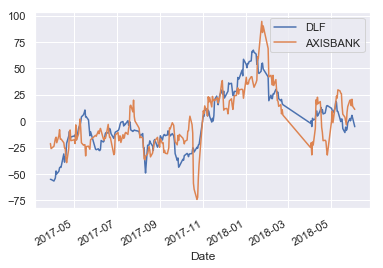

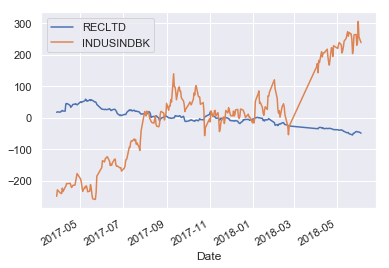

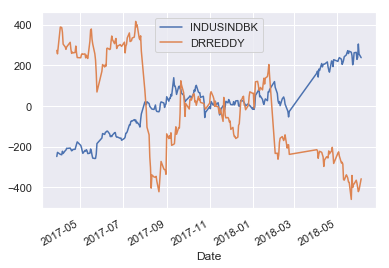

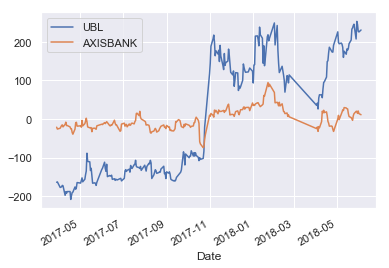

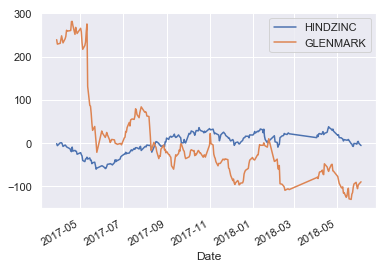

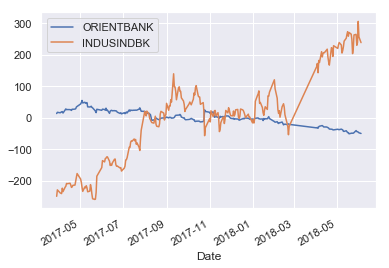

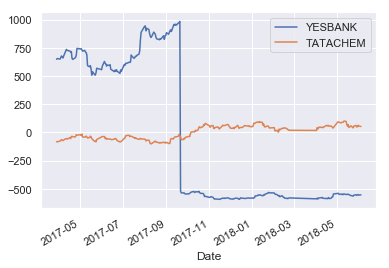

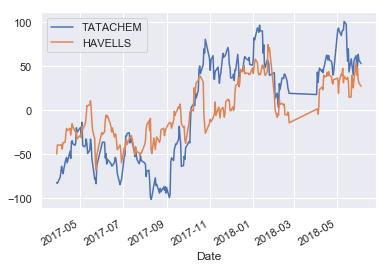

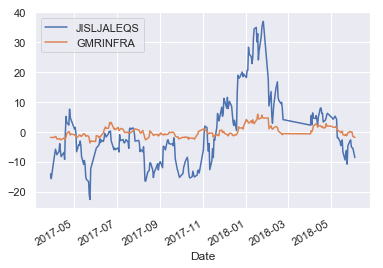

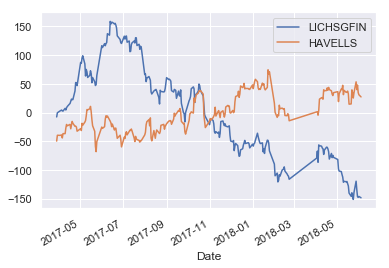

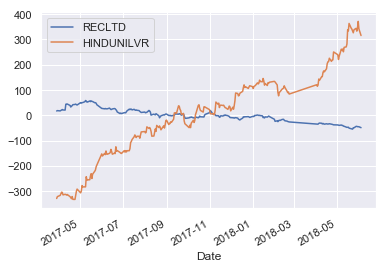

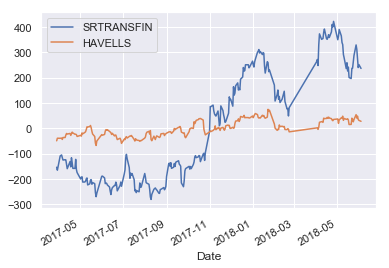

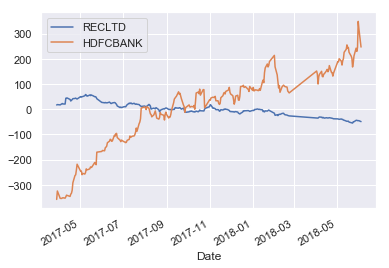

In [57]:
final_pairs=pd.DataFrame(list_sect,columns=["S1","S2"])
#Visualising cointegration in insample data 
for i,pair in final_pairs.iterrows():
        df=pd.DataFrame()
        df[pair["S1"]]=all_contracts[pair["S1"]]
        df[pair["S2"]]=all_contracts[pair["S2"]]
        data=(df-df.mean())
        data.plot()

In [58]:
final_pairs

,S1,S2
0,DLF,AXISBANK
1,RECLTD,INDUSINDBK
2,INDUSINDBK,DRREDDY
3,UBL,AXISBANK
4,HINDZINC,GLENMARK
5,ORIENTBANK,INDUSINDBK
6,YESBANK,TATACHEM
7,TATACHEM,HAVELLS
8,JISLJALEQS,GMRINFRA
9,LICHSGFIN,HAVELLS


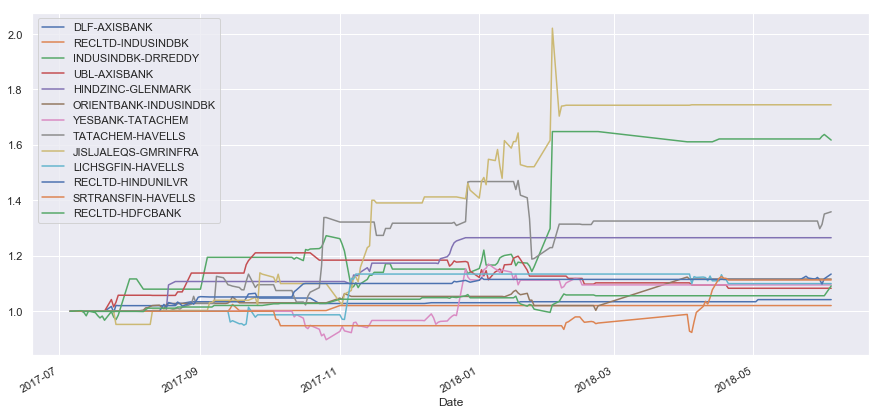

In [59]:
#Visualising results of in sample testing 
sns.set(font_scale=1)
%matplotlib inline
ret.iloc[0]=1
ret.index=all_contracts[60:].index
ret.plot(figsize=(15,7),grid=True)

In [370]:
#pd.DataFrame(list_sect).to_csv("one_pairs_20p0.05.csv")

In [371]:
"""1.csv- pairs having coint p>0.01 and sharpe > 0
 2.csv - top 20 pairs having p>0.01 and sharpe>0
 3.csv-top 5 """

'1.csv- pairs having coint p>0.01 and sharpe > 0\n 2.csv - top 20 pairs having p>0.01 and sharpe>0\n 3.csv-top 5 '

In [60]:
perf=ret.calc_stats()
perf.display()
perf.to_csv(sep=',',path="sect_trainstats.csv")

/Users/shreya/anaconda3/lib/python3.7/site-packages/ffn/core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
/Users/shreya/anaconda3/lib/python3.7/site-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Stat                 DLF-AXISBANK    RECLTD-INDUSINDBK    INDUSINDBK-DRREDDY    UBL-AXISBANK    HINDZINC-GLENMARK    ORIENTBANK-INDUSINDBK    YESBANK-TATACHEM    TATACHEM-HAVELLS    JISLJALEQS-GMRINFRA    LICHSGFIN-HAVELLS    RECLTD-HINDUNILVR    SRTRANSFIN-HAVELLS    RECLTD-HDFCBANK
-------------------  --------------  -------------------  --------------------  --------------  -------------------  -----------------------  ------------------  ------------------  ---------------------  -------------------  -------------------  --------------------  -----------------
Start                2017-07-06      2017-07-06           2017-07-06            2017-07-06      2017-07-06           2017-07-06               2017-07-06          2017-07-06          2017-07-06             2017-07-06           2017-07-06           2017-07-06            2017-07-06
End                  2018-06-04      2018-06-04           2018-06-04            2018-06-04      2018-06-04           2018-06-04               2018-0

/Users/shreya/anaconda3/lib/python3.7/site-packages/ffn/core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


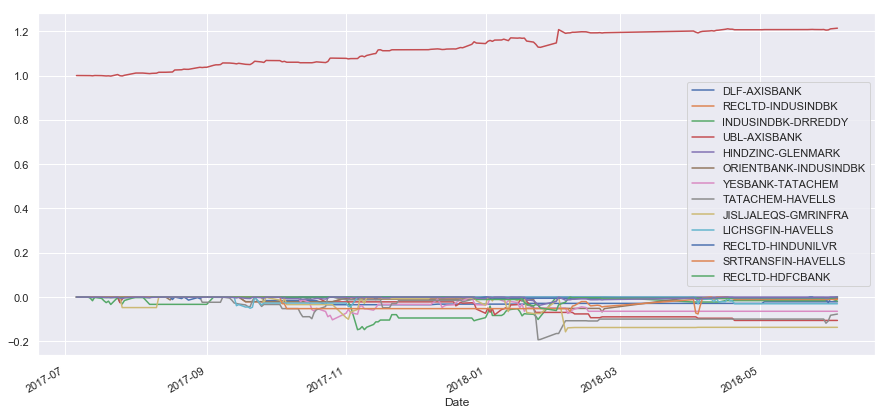

In [61]:
figr=ffn.to_drawdown_series(ret).plot(figsize=(25,10),grid=True)
figr.figure.savefig('sect_Drawdowns.png')
port=ret.mean(axis=1)
port.plot(figsize=(15,7),grid=True)
perf=port.calc_stats()
ffn.to_drawdown_series(port).plot(figsize=(15,7),grid=True)

/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shreya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.005145  0.009575  1879.80    77.75  0.415120  0.996550   
2018-09-07 -0.007777  0.000106  1880.00    77.15 -0.015069  0.449980   
2018-09-10 -0.017810 -0.022573  1838.50    75.80  0.119952  0.401383   
2018-09-11 -0.007309 -0.003466  1832.15    75.25  0.471921  0.479894   
2018-09-12 -0.007363  0.002586  1836.90    74.70  0.702312  0.512386   
2018-09-14  0.025440  0.018645  1871.80    76.65  0.522199  0.519865   
2018-09-17 -0.001306  0.004044  1879.40    76.55  0.941610  0.494796   
2018-09-18 -0.065414 -0.006049  1868.10    71.85  0.782023  0.479413   
2018-09-19  0.010331 -0.030250  1813.25    72.60  0.274990  0.546584   
2018-09-21 -0.060628 -0.024898  1769.20    68.45  0.141503  0.458405   
2018-09-24 -0.033208 -0.055011  1676.95    66.25 -0.233097  0.607672   
2018-09-25  0.010456  0.014023  1700.80    66.95 -0.165061  0.60

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.005145  0.009693  1960.25    77.75 -0.011237  0.993094   
2018-09-07 -0.007777 -0.015884  1929.60    77.15 -0.319548 -0.268761   
2018-09-10 -0.017810 -0.018742  1894.10    75.80 -0.119838 -0.261086   
2018-09-11 -0.007309 -0.009621  1876.05    75.25  0.084003 -0.228724   
2018-09-12 -0.007363  0.002340  1880.45    74.70  0.218814 -0.177662   
2018-09-14  0.025440  0.024030  1926.75    76.65  0.088045 -0.179014   
2018-09-17 -0.001306 -0.022447  1884.45    76.55  0.748175 -0.078720   
2018-09-18 -0.065414 -0.010944  1864.05    71.85  0.549910 -0.099316   
2018-09-19  0.010331 -0.014256  1837.85    72.60  0.138907 -0.005858   
2018-09-21 -0.060628 -0.000817  1836.35    68.45 -0.079974 -0.033181   
2018-09-24 -0.033208 -0.066034  1722.60    66.25 -0.530412 -0.034940   
2018-09-25  0.010456  0.029931  1775.75    66.95 -0.552801  0.14

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.004802  0.008065   117.80    83.30 -0.167479  0.987540   
2018-09-07  0.007151  0.005907   118.50    83.90 -0.140618  0.594752   
2018-09-10 -0.025046 -0.025087   115.60    81.85  0.236574  0.579716   
2018-09-11 -0.011118 -0.016711   113.70    80.95  0.279082  0.578286   
2018-09-12  0.009786  0.015158   115.45    81.75  0.671298  0.577426   
2018-09-14  0.026786  0.016610   117.40    84.00  0.448548  0.581777   
2018-09-17 -0.019417 -0.010327   116.20    82.40  0.786910  0.589736   
2018-09-18 -0.099400 -0.024240   113.45    74.95  0.815049  0.591974   
2018-09-19  0.044614 -0.004872   112.90    78.45 -0.085489  0.649222   
2018-09-21 -0.061570 -0.048769   107.65    73.90  0.048097  0.626360   
2018-09-24 -0.022130 -0.066898   100.90    72.30 -0.061229  0.667920   
2018-09-25 -0.027719  0.008841   101.80    70.35  0.183870  0.62

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.002982  0.004070   270.30    83.85  0.442935  0.989491   
2018-09-07  0.012367  0.006433   272.05    84.90  0.596129  0.720189   
2018-09-10 -0.021661 -0.025830   265.20    83.10  0.811339  0.718207   
2018-09-11 -0.013415 -0.008557   262.95    82.00  0.455425  0.731941   
2018-09-12 -0.003672  0.012765   266.35    81.70  1.083568  0.718958   
2018-09-14  0.019208  0.015888   270.65    83.30  1.159677  0.716259   
2018-09-17  0.000600 -0.008383   268.40    83.35  1.188561  0.724616   
2018-09-18 -0.049748 -0.086860   246.95    79.40  1.256566  0.723172   
2018-09-19  0.001886  0.002021   247.45    79.55  1.714454  0.698687   
2018-09-21 -0.088235 -0.029754   240.30    73.10  1.758467  0.697996   
2018-09-24 -0.054074 -0.028461   233.65    69.35  0.447517  0.735390   
2018-09-25 -0.033532  0.002774   234.30    67.10  0.042544  0.75

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.004802  0.004070   270.30    83.30  0.461224  0.999173   
2018-09-07  0.007151  0.006433   272.05    83.90  0.334218  0.937676   
2018-09-10 -0.025046 -0.025830   265.20    81.85  0.777705  0.929238   
2018-09-11 -0.011118 -0.008557   262.95    80.95  0.455631  0.939371   
2018-09-12  0.009786  0.012765   266.35    81.75  0.875198  0.934001   
2018-09-14  0.026786  0.015888   270.65    84.00  0.528296  0.932758   
2018-09-17 -0.019417 -0.008383   268.40    82.40  0.687784  0.940220   
2018-09-18 -0.099400 -0.086860   246.95    74.95  0.791127  0.941885   
2018-09-19  0.044614  0.002021   247.45    78.45  0.346934  0.969433   
2018-09-21 -0.061570 -0.029754   240.30    73.90  0.886499  0.965182   
2018-09-24 -0.022130 -0.028461   233.65    72.30  0.468740  0.984891   
2018-09-25 -0.027719  0.002774   234.30    70.35  1.025696  0.98

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.009575  0.010562   146.75  1879.80 -1.208627  0.963829   
2018-09-07  0.000106  0.012117   148.55  1880.00 -1.857756  0.092609   
2018-09-10 -0.022573 -0.010544   147.00  1838.50 -1.390505  0.089165   
2018-09-11 -0.003466 -0.041445   141.15  1832.15 -2.076114  0.096514   
2018-09-12  0.002586 -0.050223   134.40  1836.90 -2.663334  0.096123   
2018-09-14  0.018645  0.005181   135.10  1871.80 -2.287531  0.085964   
2018-09-17  0.004044  0.003687   135.60  1879.40 -0.894253  0.087690   
2018-09-18 -0.006049 -0.194188   113.55  1868.10 -1.051640  0.090821   
2018-09-19 -0.030250  0.025322   116.50  1813.25 -0.598825  0.063925   
2018-09-21 -0.024898 -0.041108   111.90  1769.20 -1.089467  0.056211   
2018-09-24 -0.055011 -0.035153   108.10  1676.95 -1.440036  0.065633   
2018-09-25  0.014023  0.015034   109.75  1700.80 -2.879071  0.08

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.008065  0.009693  1960.25   117.80  0.191989  0.996179   
2018-09-07  0.005907 -0.015884  1929.60   118.50  0.091628  0.236842   
2018-09-10 -0.025087 -0.018742  1894.10   115.60  0.399750  0.198375   
2018-09-11 -0.016711 -0.009621  1876.05   113.70  0.343465  0.247844   
2018-09-12  0.015158  0.002340  1880.45   115.45  0.254382  0.277063   
2018-09-14  0.016610  0.024030  1926.75   117.40  0.472322  0.281388   
2018-09-17 -0.010327 -0.022447  1884.45   116.20  0.647913  0.316529   
2018-09-18 -0.024240 -0.010944  1864.05   113.45  0.657649  0.328799   
2018-09-19 -0.004872 -0.014256  1837.85   112.90  0.623782  0.357015   
2018-09-21 -0.048769 -0.000817  1836.35   107.65  0.386974  0.351118   
2018-09-24 -0.066898 -0.066034  1722.60   100.90 -0.181904  0.346864   
2018-09-25  0.008841  0.029931  1775.75   101.80 -0.346016  0.57

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.006570  0.004070   270.30    38.05  0.241659  0.997991   
2018-09-07  0.005229  0.006433   272.05    38.25  0.210565  0.841477   
2018-09-10 -0.030997 -0.025830   265.20    37.10  0.573913  0.833062   
2018-09-11 -0.010899 -0.008557   262.95    36.70  0.201086  0.848258   
2018-09-12  0.002717  0.012765   266.35    36.80  0.530457  0.841570   
2018-09-14  0.041667  0.015888   270.65    38.40  0.804138  0.841761   
2018-09-17  0.027848 -0.008383   268.40    39.50  1.010068  0.859822   
2018-09-18 -0.066127 -0.086860   246.95    37.05  1.959944  0.852350   
2018-09-19 -0.004065  0.002021   247.45    36.90  1.992876  0.830283   
2018-09-21 -0.071118 -0.029754   240.30    34.45  1.787116  0.825444   
2018-09-24 -0.031437 -0.028461   233.65    33.40  1.150110  0.849861   
2018-09-25  0.004471  0.002774   234.30    33.55  1.029736  0.85

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.005145  0.012548  1263.10    77.75  0.221897  0.992234   
2018-09-07 -0.007777 -0.008624  1252.30    77.15 -0.237907  0.052688   
2018-09-10 -0.017810 -0.017468  1230.80    75.80 -0.041464  0.024878   
2018-09-11 -0.007309 -0.014173  1213.60    75.25  0.192475  0.077265   
2018-09-12 -0.007363  0.018242  1236.15    74.70  0.349018  0.073607   
2018-09-14  0.025440  0.004991  1242.35    76.65  0.190855  0.059018   
2018-09-17 -0.001306 -0.008688  1231.65    76.55  0.774445  0.058274   
2018-09-18 -0.065414 -0.009384  1220.20    71.85  0.616622  0.051606   
2018-09-19  0.010331  0.006958  1228.75    72.60  0.182565  0.114728   
2018-09-21 -0.060628 -0.041932  1179.30    68.45 -0.016248  0.146797   
2018-09-24 -0.033208 -0.024454  1151.15    66.25 -0.286615  0.349790   
2018-09-25  0.010456  0.025811  1181.65    66.95 -0.364004  0.39

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.016176  0.009525   682.45   924.20 -1.632055  0.996359   
2018-09-07  0.039493  0.004449   685.50   962.20 -1.104920  0.720534   
2018-09-10 -0.013269  0.003634   688.00   949.60 -0.460982  0.719099   
2018-09-11 -0.006625 -0.025030   671.20   943.35 -0.858514  0.719151   
2018-09-12  0.019336  0.006880   675.85   961.95 -0.270380  0.652004   
2018-09-14  0.007276  0.025661   693.65   969.00 -0.370649  0.663614   
2018-09-17 -0.018660 -0.019849   680.15   951.25 -0.171005  0.586741   
2018-09-18 -0.019451 -0.000147   680.05   933.10  0.277890  0.678175   
2018-09-19 -0.021121 -0.010851   672.75   913.80  0.318738  0.658428   
2018-09-21 -0.023923 -0.022805   657.75   892.45  0.357923  0.668284   
2018-09-24 -0.033706 -0.041815   631.35   863.35  0.234195  0.679064   
2018-09-25  0.022364  0.009569   637.45   883.10  0.041154  0.69

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.005145  0.008065   117.80    77.75 -0.390536  0.986079   
2018-09-07 -0.007777  0.005907   118.50    77.15 -0.359880  0.583561   
2018-09-10 -0.017810 -0.025087   115.60    75.80 -0.239576  0.569284   
2018-09-11 -0.007309 -0.016711   113.70    75.25  0.095453  0.557828   
2018-09-12 -0.007363  0.015158   115.45    74.70  0.389699  0.555930   
2018-09-14  0.025440  0.016610   117.40    76.65  0.120937  0.549856   
2018-09-17 -0.001306 -0.010327   116.20    76.55  0.718336  0.554749   
2018-09-18 -0.065414 -0.024240   113.45    71.85  0.571290  0.554687   
2018-09-19  0.010331 -0.004872   112.90    72.60 -0.040544  0.589372   
2018-09-21 -0.060628 -0.048769   107.65    68.45 -0.108047  0.574719   
2018-09-24 -0.033208 -0.066898   100.90    66.25 -0.407957  0.613651   
2018-09-25  0.010456  0.008841   101.80    66.95 -0.291942  0.59

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.009575  0.009693  1960.25  1879.80 -0.936338  0.995504   
2018-09-07  0.000106 -0.015884  1929.60  1880.00 -1.571102  0.086703   
2018-09-10 -0.022573 -0.018742  1894.10  1838.50 -1.068600  0.075528   
2018-09-11 -0.003466 -0.009621  1876.05  1832.15 -1.648330  0.140267   
2018-09-12  0.002586  0.002340  1880.45  1836.90 -2.105213  0.130257   
2018-09-14  0.018645  0.024030  1926.75  1871.80 -1.856006  0.129700   
2018-09-17  0.004044 -0.022447  1884.45  1879.40 -0.651535  0.180230   
2018-09-18 -0.006049 -0.010944  1864.05  1868.10 -0.661590  0.150356   
2018-09-19 -0.030250 -0.014256  1837.85  1813.25 -0.496569  0.155748   
2018-09-21 -0.024898 -0.000817  1836.35  1769.20 -0.700880  0.205485   
2018-09-24 -0.055011 -0.066034  1722.60  1676.95 -0.912071  0.206863   
2018-09-25  0.014023  0.029931  1775.75  1700.80 -1.468969  0.42

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.012774  0.018476   284.15   454.05 -0.070884  0.992969   
2018-09-07 -0.009673  0.011652   287.50   449.70  0.050170  0.660625   
2018-09-10 -0.043751 -0.022041   281.30   430.85 -0.096514  0.625208   
2018-09-11 -0.001860  0.008809   283.80   430.05  0.180333  0.694378   
2018-09-12 -0.028459 -0.006205   282.05   418.15  0.113941  0.688517   
2018-09-14  0.006770 -0.012020   278.70   421.00 -0.142982  0.700301   
2018-09-17 -0.022962 -0.008869   276.25   411.55  0.313729  0.718129   
2018-09-18 -0.047468 -0.005460   274.75   392.90  0.169250  0.728004   
2018-09-19 -0.086109  0.024152   281.55   361.75 -0.226886  0.742891   
2018-09-21 -0.074239 -0.018632   276.40   336.75 -0.674390  0.575742   
2018-09-24 -0.059795  0.019858   282.00   317.75 -0.561056  0.679296   
2018-09-25 -0.002840 -0.021184   276.15   316.85 -1.273991  0.57

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.012548 -0.016109    40.35  1263.10 -0.223869  0.947113   
2018-09-07 -0.008624  0.009816    40.75  1252.30 -1.031893 -0.019815   
2018-09-10 -0.017468 -0.020025    39.95  1230.80 -0.937074 -0.037730   
2018-09-11 -0.014173  0.012361    40.45  1213.60 -1.441111 -0.030362   
2018-09-12  0.018242 -0.016332    39.80  1236.15 -1.574267 -0.041273   
2018-09-14  0.004991  0.024510    40.80  1242.35 -1.069102 -0.045853   
2018-09-17 -0.008688  0.000000    40.80  1231.65 -0.761176 -0.042100   
2018-09-18 -0.009384 -0.038168    39.30  1220.20 -1.011869 -0.041913   
2018-09-19  0.006958 -0.003831    39.15  1228.75 -1.061278 -0.034683   
2018-09-21 -0.041932 -0.042610    37.55  1179.30 -0.670233 -0.031428   
2018-09-24 -0.024454 -0.038728    36.15  1151.15 -1.878716  0.007549   
2018-09-25  0.025811  0.038564    37.60  1181.65 -2.795388  0.02

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.009693  0.010562   146.75  1960.25 -0.834689  0.959357   
2018-09-07 -0.015884  0.012117   148.55  1929.60 -0.478405  0.011945   
2018-09-10 -0.018742 -0.010544   147.00  1894.10 -0.746124  0.006216   
2018-09-11 -0.009621 -0.041445   141.15  1876.05 -0.766201  0.010749   
2018-09-12  0.002340 -0.050223   134.40  1880.45 -1.501584  0.021027   
2018-09-14  0.024030  0.005181   135.10  1926.75 -1.431342  0.017516   
2018-09-17 -0.022447  0.003687   135.60  1884.45 -0.821736  0.020221   
2018-09-18 -0.010944 -0.194188   113.55  1864.05 -1.617868  0.021975   
2018-09-19 -0.014256  0.025322   116.50  1837.85 -1.706561  0.038074   
2018-09-21 -0.000817 -0.041108   111.90  1836.35 -1.999493  0.032850   
2018-09-24 -0.066034 -0.035153   108.10  1722.60 -2.302272  0.032495   
2018-09-25  0.029931  0.015034   109.75  1775.75 -3.504246  0.05

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.004802  0.009693  1960.25    83.30  0.121588  0.995037   
2018-09-07  0.007151 -0.015884  1929.60    83.90 -0.132516 -0.134363   
2018-09-10 -0.025046 -0.018742  1894.10    81.85  0.255543 -0.178496   
2018-09-11 -0.011118 -0.009621  1876.05    80.95  0.239932 -0.122861   
2018-09-12  0.009786  0.002340  1880.45    81.75  0.499447 -0.048135   
2018-09-14  0.026786  0.024030  1926.75    84.00  0.403075 -0.041451   
2018-09-17 -0.019417 -0.022447  1884.45    82.40  0.787224  0.056639   
2018-09-18 -0.099400 -0.010944  1864.05    74.95  0.821708  0.117528   
2018-09-19  0.044614 -0.014256  1837.85    78.45  0.238865  0.255286   
2018-09-21 -0.061570 -0.000817  1836.35    73.90  0.149981  0.156170   
2018-09-24 -0.022130 -0.066034  1722.60    72.30 -0.161151  0.166059   
2018-09-25 -0.027719  0.029931  1775.75    70.35 -0.181990  0.20

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.004802  0.009575  1879.80    83.30  0.539477  0.997435   
2018-09-07  0.007151  0.000106  1880.00    83.90  0.095515  0.411031   
2018-09-10 -0.025046 -0.022573  1838.50    81.85  0.426544  0.351934   
2018-09-11 -0.011118 -0.003466  1832.15    80.95  0.526905  0.440996   
2018-09-12  0.009786  0.002586  1836.90    81.75  0.871267  0.484235   
2018-09-14  0.026786  0.018645  1871.80    84.00  0.788234  0.527369   
2018-09-17 -0.019417  0.004044  1879.40    82.40  0.979217  0.574745   
2018-09-18 -0.099400 -0.006049  1868.10    74.95  0.969073  0.571049   
2018-09-19  0.044614 -0.030250  1813.25    78.45  0.263806  0.679739   
2018-09-21 -0.061570 -0.024898  1769.20    73.90  0.229408  0.429802   
2018-09-24 -0.022130 -0.055011  1676.95    72.30 -0.003754  0.586676   
2018-09-25 -0.027719  0.014023  1700.80    70.35  0.085139  0.52

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.013642 -0.005000   330.00   340.85 -1.170621  0.986397   
2018-09-07 -0.047319  0.017711   335.95   325.45 -1.139149  0.223469   
2018-09-10  0.000000 -0.007497   333.45   325.45 -1.192883  0.186626   
2018-09-11 -0.024717 -0.015996   328.20   317.60 -1.173626  0.187233   
2018-09-12 -0.005700 -0.010002   324.95   315.80 -1.325923  0.202912   
2018-09-14  0.023651  0.013210   329.30   323.45 -1.250706  0.203360   
2018-09-17 -0.014268 -0.008421   326.55   318.90 -1.361707  0.216680   
2018-09-18  0.014676 -0.020309   320.05   323.65 -1.565016  0.221760   
2018-09-19 -0.010775  0.006673   322.20   320.20 -0.983728  0.213988   
2018-09-21 -0.408401 -0.012412   318.25   227.35 -1.278487  0.203922   
2018-09-24 -0.001983 -0.027939   309.60   226.90 -2.453931  0.489566   
2018-09-25 -0.031129  0.005461   311.30   220.05 -2.465257  0.46

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.001677 -0.005000   330.00   298.15 -1.154740  0.994751   
2018-09-07 -0.015843  0.017711   335.95   293.50 -1.036024  0.714405   
2018-09-10 -0.024254 -0.007497   333.45   286.55 -0.742965  0.695499   
2018-09-11 -0.009157 -0.015996   328.20   283.95 -1.781549  0.723634   
2018-09-12  0.010282 -0.010002   324.95   286.90 -1.180126  0.732095   
2018-09-14  0.015949  0.013210   329.30   291.55 -0.849611  0.724548   
2018-09-17 -0.017627 -0.008421   326.55   286.50 -0.142285  0.725528   
2018-09-18 -0.041250 -0.020309   320.05   275.15 -0.063599  0.727199   
2018-09-19 -0.008799  0.006673   322.20   272.75 -0.259602  0.755693   
2018-09-21 -0.005715 -0.012412   318.25   271.20 -0.336790  0.747918   
2018-09-24 -0.023203 -0.027939   309.60   265.05 -0.843215  0.782856   
2018-09-25  0.021775  0.005461   311.30   270.95 -1.287098  0.78

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.001678 -0.005000   330.00    59.60 -0.484633  0.997740   
2018-09-07  0.012428  0.017711   335.95    60.35 -0.244534  0.761171   
2018-09-10 -0.039621 -0.007497   333.45    58.05 -0.480626  0.760228   
2018-09-11 -0.006066 -0.015996   328.20    57.70 -0.248146  0.724650   
2018-09-12  0.007739 -0.010002   324.95    58.15  0.078671  0.731143   
2018-09-14  0.012733  0.013210   329.30    58.90  0.238595  0.720415   
2018-09-17 -0.009426 -0.008421   326.55    58.35  0.287961  0.723676   
2018-09-18 -0.033658 -0.020309   320.05    56.45  0.325863  0.721914   
2018-09-19  0.014834  0.006673   322.20    57.30  0.370232  0.750962   
2018-09-21 -0.019573 -0.012412   318.25    56.20  0.181203  0.736613   
2018-09-24 -0.063387 -0.027939   309.60    52.85 -0.123746  0.776021   
2018-09-25 -0.016346  0.005461   311.30    52.00 -0.547110  0.83

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06  0.014038  0.005260  1568.30   227.95 -0.201829  0.998057   
2018-09-07  0.004802  0.009662  1583.60   229.05  0.271782  0.883955   
2018-09-10 -0.035957 -0.029214  1538.65   221.10 -0.062242  0.887110   
2018-09-11 -0.001359 -0.007003  1527.95   220.80 -0.085163  0.897436   
2018-09-12  0.028810  0.021329  1561.25   227.35  0.181822  0.895694   
2018-09-14  0.016014  0.027562  1605.50   231.05  0.489040  0.902575   
2018-09-17 -0.017169 -0.009558  1590.30   227.15  0.489702  0.897636   
2018-09-18 -0.010903 -0.012414  1570.80   224.70  0.451970  0.899272   
2018-09-19  0.004210 -0.002137  1567.45   225.65  0.386547  0.896400   
2018-09-21 -0.001776 -0.014859  1544.50   225.25  0.694415  0.895323   
2018-09-24 -0.027835 -0.012787  1525.00   219.15  0.972819  0.887588   
2018-09-25  0.028806  0.026865  1567.10   225.65  0.270424  0.89

                   y         x  x_price  y_price    zScore        hr  \
Date                                                                   
2018-09-06 -0.005145 -0.005000   330.00    77.75 -1.095972  1.004642   
2018-09-07 -0.007777  0.017711   335.95    77.15 -1.168116  1.111928   
2018-09-10 -0.017810 -0.007497   333.45    75.80 -1.110209  1.097227   
2018-09-11 -0.007309 -0.015996   328.20    75.25 -1.023175  1.083281   
2018-09-12 -0.007363 -0.010002   324.95    74.70 -0.317009  1.090200   
2018-09-14  0.025440  0.013210   329.30    76.65 -0.162184  1.088776   
2018-09-17 -0.001306 -0.008421   326.55    76.55  0.579103  1.093818   
2018-09-18 -0.065414 -0.020309   320.05    71.85  0.273992  1.096171   
2018-09-19  0.010331  0.006673   322.20    72.60  0.086948  1.155114   
2018-09-21 -0.060628 -0.012412   318.25    68.45 -0.011690  1.146264   
2018-09-24 -0.033208 -0.027939   309.60    66.25 -1.137757  1.245120   
2018-09-25  0.010456  0.005461   311.30    66.95 -1.074425  1.23

/Users/shreya/anaconda3/lib/python3.7/site-packages/ffn/core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


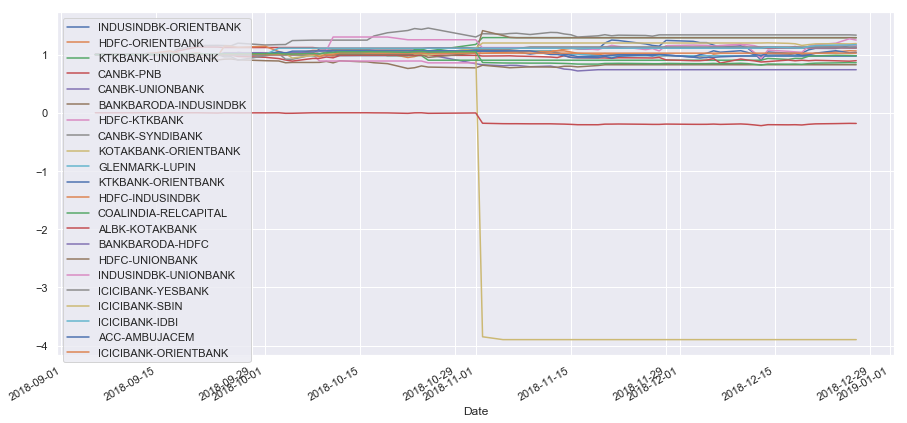

In [85]:
testing_data=pd.read_csv('data_needed.csv',index_col='Date',parse_dates=True)
testing_data=testing_data[1220-252:1220]

test_ret=pd.DataFrame()
number_pairs=len(list_sect)
for i in np.arange(number_pairs):
    s1=list_sect[i][1]
    s2=list_sect[i][0]
    name=s1+"-"+s2
    x=testing_data[s1]
    y=testing_data[s2]
    test_ret[name],sharpe=backtest(s1,s2,x,y)
test_ret.iloc[0]=1
figr=test_ret.plot(figsize=(10,7))
figr.figure.savefig("sect_testing_returns.png")
port=test_ret.mean(axis=1)
figr=port.plot(figsize=(15,7),grid=True)
figr.figure.savefig('sect_backtesting.png')
perf=port.calc_stats()

figr=ffn.to_drawdown_series(port).plot(figsize=(15,7),grid=True)
figr.figure.savefig('sect_Max_Drawdowns.png')



In [86]:
perf.display()

Stats for None from 2018-09-06 00:00:00 - 2018-12-27 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR     Max Drawdown
--------------  --------  -------  --------------
-14.04%            -1.38  -38.95%  -22.11%

Annualized Returns:
mtd    3m       6m    ytd      1y    3y    5y    10y    incep.
-----  -------  ----  -------  ----  ----  ----  -----  --------
1.37%  -15.18%  -     -14.04%  -     -     -     -      -38.95%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -1.38    -1.39      -
mean    -49.66%  -57.67%    -
vol     36.05%   41.63%     -
skew    -7.15    -1.70      -
kurt    55.87    -          -
best    2.12%    2.87%      -
worst   -17.73%  -18.66%    -

Drawdowns:
max      avg       # days
-------  ------  --------
-22.11%  -4.13%        14

Misc:
---------------  -------
avg. up month    2.12%
avg. down month  -18.66%
up year %        -
12m up %         -
---------------  -------


In [65]:
perf2=perf.stats
perf2.to_csv(sep=',',path="sect_test_stats.csv")

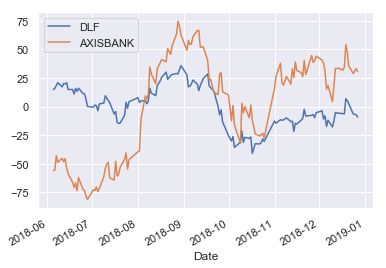

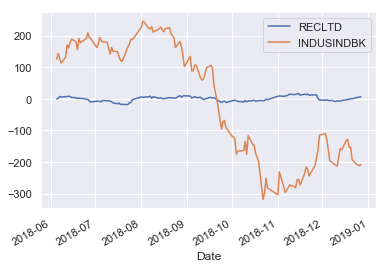

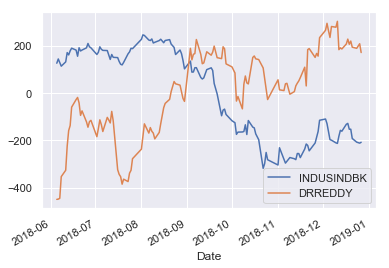

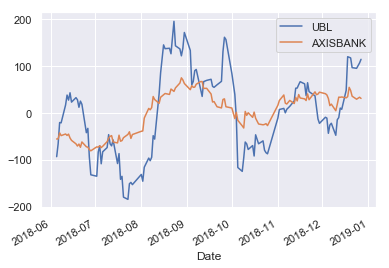

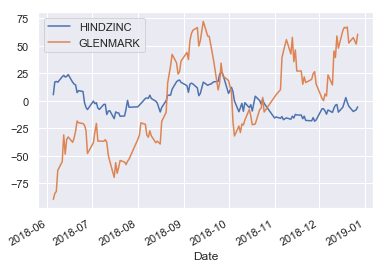

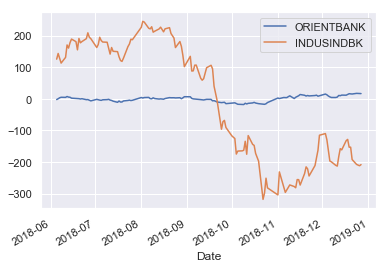

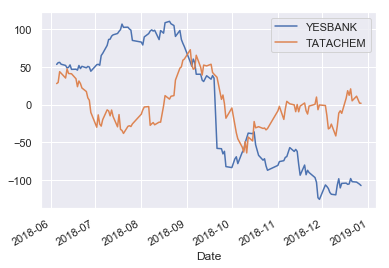

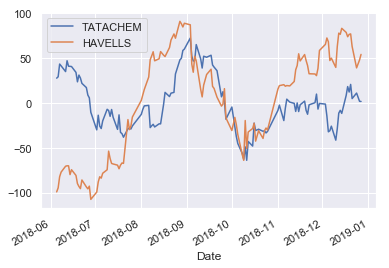

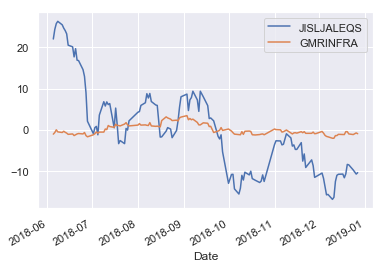

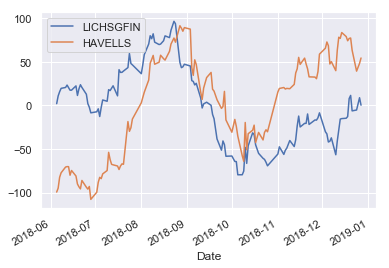

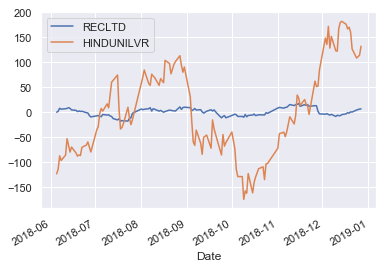

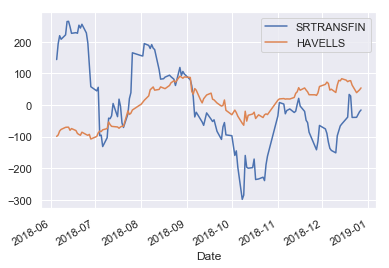

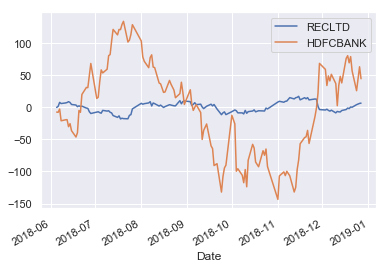

In [66]:
#Visualising cointegration in out of sample data 
final_pairs=pd.DataFrame(list_sect,columns=["S1","S2"])
for i,pair in final_pairs.iterrows():
        df=pd.DataFrame()
        df[pair["S1"]]=testing_data[pair["S1"]]
        df[pair["S2"]]=testing_data[pair["S2"]]
        data=(df-df.mean())
        fig=data.plot()